#Import Library

---



In [52]:
import zipfile
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from tensorflow.keras.applications import VGG16, InceptionResNetV2
from keras import regularizers
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax

In [53]:
plt.style.use('seaborn')

#Load Data

Dataset Link (Google Drive)

In [54]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [55]:
link = 'https://drive.google.com/file/d/1m7IbaONTgIL1uRDWty8uOQp_DISjV175/view?usp=sharing' # The shareable link

In [56]:
# fluff, id = link.split('d/')
id = link.split('d/')[1].split('/view?')[0]
print (id)

1m7IbaONTgIL1uRDWty8uOQp_DISjV175


In [57]:
# Use this to download easily (only on google colab)
!gdown --id 1m7IbaONTgIL1uRDWty8uOQp_DISjV175

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1m7IbaONTgIL1uRDWty8uOQp_DISjV175
To: /content/emotion1.zip
100% 68.3M/68.3M [00:00<00:00, 374MB/s]


In [ ]:
downloaded = drive.CreateFile({'id':id})  #drive from PyDrive
downloaded.GetContentFile('emotion1.zip')

In [59]:
file_zip = 'emotion1.zip'
zip_ref = zipfile.ZipFile(file_zip, 'r')
zip_ref.extractall('./emotion1/')
zip_ref.close()

In [60]:
import os
import shutil

def delete(path):
    """path could either be relative or absolute. """
    # check if file or directory exists
    if os.path.isfile(path) or os.path.islink(path):
        # remove file
        os.remove(path)
    elif os.path.isdir(path):
        # remove directory and all its content
        shutil.rmtree(path)
    else:
        raise ValueError("Path {} is not a file or dir.".format(path))

# directory
delete(r'/content/emotion1/train/angry')
delete(r'/content/emotion1/train/surprised')
delete(r'/content/emotion1/train/fearful')
delete(r'/content/emotion1/train/disgusted')

delete(r'/content/emotion1/test/angry')
delete(r'/content/emotion1/test/surprised')
delete(r'/content/emotion1/test/fearful')
delete(r'/content/emotion1/test/disgusted')



In [61]:
dir = './emotion1/train'
testing_dir = './emotion1/test'

list_category = sorted(os.listdir(dir))
test_list_category = sorted(os.listdir(testing_dir))

print('train category: ',list_category)
print('test category: ',test_list_category)

train category:  ['happy', 'neutral', 'sad']
test category:  ['happy', 'neutral', 'sad']


#

#Data Arrange

In [62]:
import tensorflow as tf
import matplotlib.pyplot as plt
print (tf.__version__)
from keras.preprocessing.image import ImageDataGenerator

2.8.2


In [63]:
# train_dir = dir + 'train/'
# test_dir = dir + 'test/'

train_dir = dir
test_dir = testing_dir

In [64]:
target_var = os.listdir(train_dir)
target_var

['neutral', 'happy', 'sad']

In [65]:
test_target_var = os.listdir(testing_dir)
test_target_var

['neutral', 'happy', 'sad']

In [66]:
# check a lot of data for :
# {'happy': 0, 'neutral': 1, 'sad': 2}
print("Train Data")

happy_dir = os.path.join(train_dir, 'happy')
neutral_dur = os.path.join(train_dir,'neutral')
sad_dir = os.path.join(train_dir, 'sad')

print("happy :", len(os.listdir(happy_dir)))
print("neutral :", len(os.listdir(neutral_dur)))
print("sad :", len(os.listdir(sad_dir))) 

Train Data
happy : 7215
neutral : 4965
sad : 4830


In [67]:
from glob import glob

happy = glob(happy_dir + '/*.jpg') + glob(happy_dir + '/*.png')
neutral = glob(neutral_dur + '/*.jpg') + glob(neutral_dur + '/*.png')
sad = glob(sad_dir + '/*.jpg') + glob(sad_dir + '/*.png')

In [68]:
def category_decide(x):
  value = 0

  if 'happy' in x:
    value = 0
  elif 'neutral' in x:
    value = 1
  else:
    value = 2
  return value

df = pd.DataFrame(columns=['image', 'target'])
df['image'] = happy + neutral + sad 
df['target'] = df['image'].apply(lambda x: category_decide(x))  
df = df.sample(frac=1).reset_index(drop=True)

df.head(20)

,image,target
0,./emotion1/train/happy/im7212.png,0
1,./emotion1/train/sad/im3421.png,2
2,./emotion1/train/happy/im3709.png,0
3,./emotion1/train/sad/im1444.png,2
4,./emotion1/train/happy/im6241.png,0
5,./emotion1/train/neutral/im3185.png,1
6,./emotion1/train/happy/im6453.png,0
7,./emotion1/train/happy/im3588.png,0
8,./emotion1/train/sad/im102.png,2
9,./emotion1/train/happy/im2954.png,0


In [69]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(
    df, 
    test_size=0.4, 
    random_state=14, 
    stratify=df['target']
)
val_df, test_df = train_test_split(
    test_df, 
    test_size=0.1, 
    random_state=14, 
    stratify=test_df['target']
)

print("Train: {}".format(train_df.shape))
print("happy  : {}".format(train_df[train_df['target'] == 0].shape[0]))
print("neutral  : {}".format(train_df[train_df['target'] == 1].shape[0]))
print("sad: {}".format(train_df[train_df['target'] == 2].shape[0]))

print("\nVal: {}".format(val_df.shape))
print("happy  : {}".format(val_df[val_df['target'] == 0].shape[0]))
print("neutral  : {}".format(val_df[val_df['target'] == 1].shape[0]))
print("sad: {}".format(val_df[val_df['target'] == 2].shape[0]))


print("\nTest : {}".format(test_df.shape))
print("happy  : {}".format(test_df[test_df['target'] == 0].shape[0]))
print("neutral  : {}".format(test_df[test_df['target'] == 1].shape[0]))
print("sad: {}".format(test_df[test_df['target'] == 2].shape[0]))

Train: (10206, 2)
happy  : 4329
neutral  : 2979
sad: 2898

Val: (6123, 2)
happy  : 2597
neutral  : 1787
sad: 1739

Test : (681, 2)
happy  : 289
neutral  : 199
sad: 193


In [70]:
train_df.tail()

,image,target
10227,./emotion1/train/sad/im1229.png,2
13682,./emotion1/train/happy/im5335.png,0
5051,./emotion1/train/neutral/im20.png,1
14541,./emotion1/train/sad/im1120.png,2
12783,./emotion1/train/neutral/im4172.png,1


In [71]:
val_df.head()

,image,target
442,./emotion1/train/happy/im7162.png,0
13586,./emotion1/train/neutral/im4263.png,1
14250,./emotion1/train/neutral/im488.png,1
2112,./emotion1/train/neutral/im2096.png,1
4076,./emotion1/train/happy/im3356.png,0


In [72]:
test_df.head()

,image,target
1917,./emotion1/train/neutral/im815.png,1
10464,./emotion1/train/sad/im1475.png,2
15962,./emotion1/train/happy/im3091.png,0
5636,./emotion1/train/happy/im104.png,0
16161,./emotion1/train/neutral/im4282.png,1


#EDA

In [73]:
print(list_category)

['happy', 'neutral', 'sad']


#Arrange

In [74]:
# check a lot of data for paper, rock and scissors
for  item in list_category:
  class_dir = os.path.join(dir,item)
  print(item ," : ",len(os.listdir(class_dir)),"images")

happy  :  7215 images
neutral  :  4965 images
sad  :  4830 images


In [75]:
# check image (count, size, total)
from PIL import Image
total = 0

for x in list_category:
  dir_cat = os.path.join(dir, x)
  y = len(os.listdir(dir_cat))
  print(x+':', y)
  total = total + y
  
  size = (0,0)
  img_name = os.listdir(dir_cat)
  for i in range(5):
    img_path = os.path.join(dir_cat, img_name[i])
    img = Image.open(img_path)
    
    if size == img.size:
      continue
    else :
      size = img.size
      print('+ size = ',img.size)

print('\nTotal :', total)

happy: 7215
+ size =  (48, 48)
neutral: 4965
+ size =  (48, 48)
sad: 4830
+ size =  (48, 48)

Total : 17010


happy


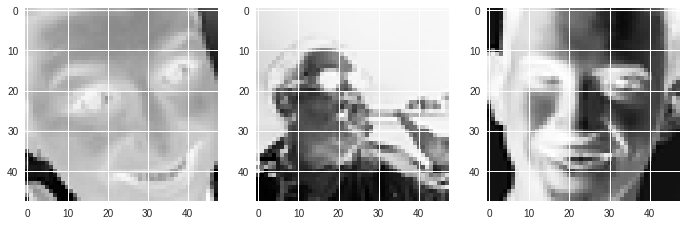

neutral


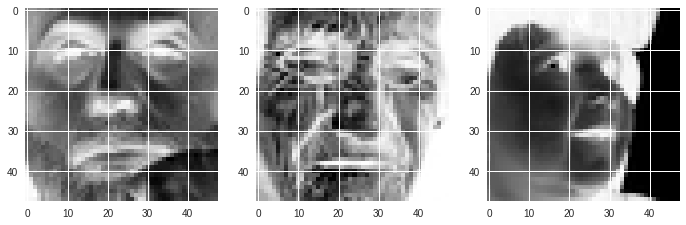

sad


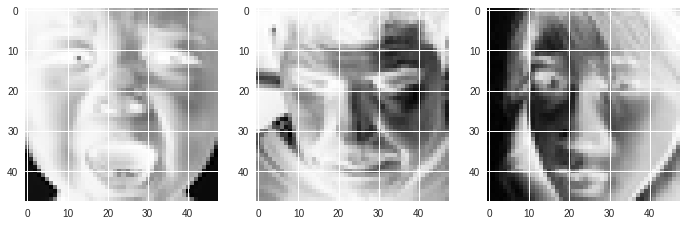

In [76]:
import matplotlib.image as mpimg

# check images class
for  item in list_category:
  print(item)
  class_dir = os.path.join(dir,item)
  class_images = os.listdir(class_dir)
  plt.figure(figsize=(20, 4))
  for i, img_path in enumerate(class_images[:3]):
    sp = plt.subplot(1, 5, i+1)
    img = mpimg.imread(os.path.join(class_dir, img_path))
    plt.imshow(img)
  plt.show()

#Preprocessing

In [77]:
dim = 48

def decode_image(filename, label=None, image_size=(dim, dim)):
    """
    Decode, normalize, and resize the image

    Parameters
    ----------
    filename: str
        The image file's name
    label: int, optional
        The image's label (default is None)
    image_size: tuple of int, optional
        The image's size. (default is (256, 256))

    Returns
    -------
    image:
        Decoded image
    label: optional
        One-hot encoded label
    """

    bits = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits, channels=3)
    image = tf.cast(image, tf.float32)  # Convert to float32
    image /= 255.0  # Normalize
    image = tf.image.resize(image, image_size)  #Resize
    
    if label == None:
        return image
    else:
        return image, tf.one_hot(label, depth=len(list_category))


In [78]:
AUTO = tf.data.experimental.AUTOTUNE
batch_size = 128

In [79]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((train_df['image'], train_df['target']))
    .map(decode_image, num_parallel_calls=AUTO)
    # .map(image_augment, num_parallel_calls=AUTO)
    .repeat()
    .shuffle(512)
    .batch(batch_size)
    .prefetch(AUTO)
)

val_dataset = (
    tf.data.Dataset
    .from_tensor_slices((val_df['image'], val_df['target']))
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(batch_size)
    .cache()
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices((test_df['image'], test_df['target']))
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(batch_size)
    .cache()
    .prefetch(AUTO)
)

In [80]:
for img, label in train_dataset.take(1):
    print("Image shape: {}".format(img.numpy().shape))
    print("Label shape: {}".format(label.numpy().shape))

Image shape: (128, 48, 48, 3)
Label shape: (128, 3)


In [81]:
for img, label in val_dataset.take(1):
    print("Image shape: {}".format(img.numpy().shape))
    print("Label shape: {}".format(label.numpy().shape))

Image shape: (128, 48, 48, 3)
Label shape: (128, 3)


In [82]:
for img, label in test_dataset.take(1):
    print("Image shape: {}".format(img.numpy().shape))
    print("Label shape: {}".format(label.numpy().shape))

Image shape: (128, 48, 48, 3)
Label shape: (128, 3)


In [83]:
def plot_dataset(dataset, rows, cols):
    """
    Plot dataset

    Parameters
    ----------
    dataset: tf.data.Dataset
        Dataset that has been processed
    rows: int
        Number of rows in plot
    cols: int 
        Number of columns in plot
    """
    for img, label in train_dataset.take(1):
        for i in range(rows*cols):
            ax = plt.subplot(rows, cols, i+1)
            plt.imshow(img[i].numpy())

            # Set the title's color
            if list_category[np.argmax(label[i].numpy())] == 'happy':
                color = 'green'
            elif list_category[np.argmax(label[i].numpy())] == 'neutral':
                color = 'orange'
            elif list_category[np.argmax(label[i].numpy())] == 'sad':
                color = 'red'


            plt.title(list_category[np.argmax(label[i].numpy())], color=color)
            plt.axis('off')
            plt.grid(False)

        plt.show()

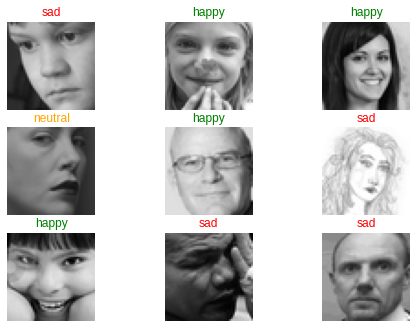

In [84]:
plot_dataset(list_category, 3, 3)

In [85]:
label_types = []
for i in list_category:
  label_types.append(i)
label_types

['happy', 'neutral', 'sad']

In [86]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(48, 48, 3)),
    tf.keras.layers.Dropout(0.2), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2), 
    tf.keras.layers.Dense(3, activation='softmax')  
])



In [87]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 46, 46, 16)        448       
                                                                 
 dropout_2 (Dropout)         (None, 46, 46, 16)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 23, 23, 16)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 21, 21, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 10, 10, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 8, 8, 64)         

In [ ]:
do_fine_tuning = False 

if do_fine_tuning:
    optimizer = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9)
else:
    optimizer = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9)

model.compile(loss = 'categorical_crossentropy',
              optimizer = optimizer,
              metrics=['accuracy'])

Fitting Model

In [89]:
# fitting model
history = model.fit(
    train_dataset,
    steps_per_epoch = len(train_df) // batch_size,
    epochs = 200,
    validation_data = val_dataset,
    validation_steps = len(val_df) // batch_size,
  
)

Epoch 1/200
79/79 [==============================] - 10s 116ms/step - loss: 1.0873 - accuracy: 0.4249 - val_loss: 1.0818 - val_accuracy: 0.4269
Epoch 2/200
79/79 [==============================] - 9s 109ms/step - loss: 1.0808 - accuracy: 0.4236 - val_loss: 1.0793 - val_accuracy: 0.4269
Epoch 3/200
79/79 [==============================] - 8s 105ms/step - loss: 1.0792 - accuracy: 0.4254 - val_loss: 1.0788 - val_accuracy: 0.4269
Epoch 4/200
79/79 [==============================] - 8s 100ms/step - loss: 1.0797 - accuracy: 0.4232 - val_loss: 1.0786 - val_accuracy: 0.4269
Epoch 5/200
79/79 [==============================] - 5s 61ms/step - loss: 1.0796 - accuracy: 0.4233 - val_loss: 1.0785 - val_accuracy: 0.4269
Epoch 6/200
79/79 [==============================] - 5s 60ms/step - loss: 1.0794 - accuracy: 0.4234 - val_loss: 1.0783 - val_accuracy: 0.4269
Epoch 7/200
79/79 [==============================] - 4s 51ms/step - loss: 1.0783 - accuracy: 0.4255 - val_loss: 1.0782 - val_accuracy: 0.4269
E

#Visualize the Result

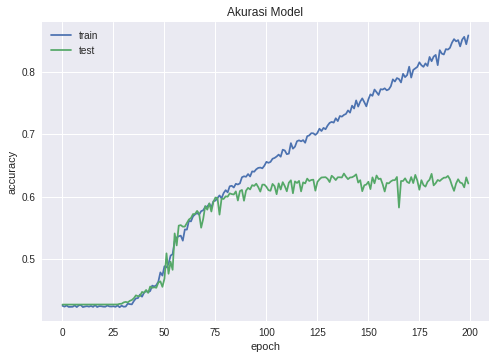

In [90]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Akurasi Model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

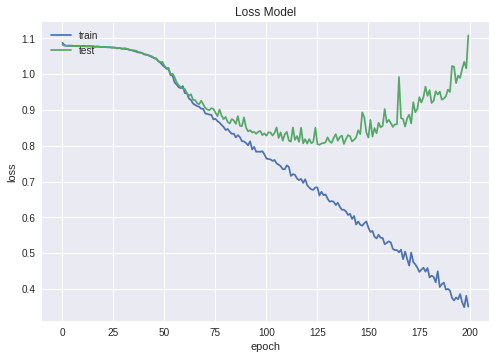

In [91]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#Test model

Saving images (1).jpg to images (1) (3).jpg
Sad


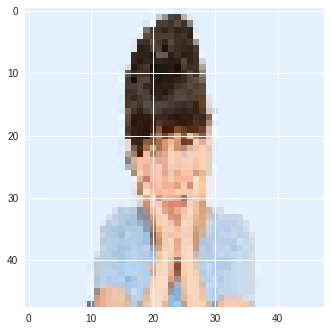

In [98]:
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for path in uploaded.keys():
  img = image.load_img(path, target_size=(dim,dim))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])
  images /= 255 # because on train and test image is normalized, on image predict supposed to be too.
  classes = model.predict(images, batch_size=32) # the value is not always 1 and 0 because of probabilities
  predicted_class_indices=np.argmax(classes) # use to check prediction that have higher probabilities

# if predicted_class_indices == 0:
#     print('Angry')
# elif predicted_class_indices == 1:
#   print('Fearful')
# elif predicted_class_indices == 2:
#   print('Happy')
# elif predicted_class_indices == 3:
#   print('Neutral')
# elif predicted_class_indices == 4:
#   print('Sad')
# elif predicted_class_indices == 5:
#   print('Surprised')

if predicted_class_indices == 0:#Happy
  print('Happy')
elif predicted_class_indices == 1:#Neutral
  print('Neutral')
elif predicted_class_indices == 2:#Sad
  print('Sad')

#Save Model

In [ ]:
import tempfile
MODEL_DIR = tempfile.gettempdir()

version = 1

export_path = os.path.join(MODEL_DIR, str(version))

if os.path.isdir(export_path):
    print('\nAlready saved a model, cleaning up\n')
    !rm -r {export_path}

model.save(export_path, save_format="tf")

print('\nexport_path = {}'.format(export_path))
!ls -l {export_path}

In [ ]:
# Intialize the TFLite converter to load the SavedModel
converter = tf.lite.TFLiteConverter.from_saved_model(export_path)

# Set the optimization strategy for 'size' in the converter 
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]

# Use the tool to finally convert the model
tflite_model = converter.convert()

# Write TFLite model
tflite_model_file = 'emotion_clasification_01.tflite'

with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)

with open('emotion_clasification_01.txt', 'w') as f:
    f.write('\n'.join(label_types))

In [95]:
model.save('emotion_clasification_01.h5')

In [ ]:
import pickle

pickle.dump(model, open('emotion_clasification_01.pkl', 'wb'))

In [ ]:
pickled_model = pickle.load(open('emotion_clasification_01.pkl', 'rb'))
pickled_model.predict()